Heterogenous Diffusion in Diffusion-Reaction Equation

Transport Equation
$$ \frac{\partial u}{\partial t} = D\ \frac{\partial\ ^2 u}{\partial x^2}\ ,\ \quad 0 < x < L\ , t > 0$$
Initial Condition: 
$$ u(x,0) = f(x)\ ,\ \quad 0 \leq x \leq L $$
Boundary Conditions:
$$ a_0 u(0,t) + b_0 \frac{\partial u}{\partial x} (0,t) = c_0\ ,\ \quad \frac{\partial u}{\partial x} (L,t) = 0\ ,\ \quad t > 0$$


Initialisation:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialise Inputs
L = 1                                   # length of domain
D = lambda x: 0.1 + 0.05*np.sin(40*x)   # diffusivity
a0 = 1                                  # boundary condition coefficient
c0 = 1                                  # boundary condition coefficient
b0 = D(0)                               # boundary condition coefficient
N = 201                                 # number of nodes
f = lambda x: np.zeros(x.size)          # initial solution
x = np.linspace(0,L,N)                  # node positions
xt = np.vstack(x)                       # node positions as a column vector
T = 8                                   # end time
M = 800                                 # number of time steps

Numerical Solution:

In [2]:
def numerical_solution(D,f,a0,b0,c0,x,M,T):
    # Inputs
    #   D: Diffusivity (function handle)
    #   f: Initial solution (function handle)
    #   a0: boundary condition coefficient (constant non-negative scalar)
    #   b0: boundary condition coefficient (constant non-negative scalar)
    #   c0: boundary condition coefficient (constant scalar)
    #   x: node locations (vector)
    #   M: number of time steps (positive integer)
    #   T: end time (positive number)
    # Outputs
    #   u: Solution (matrix of size N by M+1), where u(i,j) is the solution u(x,t) evaluated
    #      at x = x(i) and t = (j-1)*dt

    # Initialise Constants
    dt = T/M # time stepsize
    N = x.size # number of nodes


    # Node Spacings
    xt = np.vstack(x)               # node positions as a column vector
    xtdf = pd.DataFrame(xt)         # convert xt to a pandas dataframe
    h = xtdf.diff().to_numpy()      # node spacings (converted back to numpy)
    h[0] = h[1]                     # fix NaN value in first element


    # Control Volume Boundaries
    w  = np.zeros(N)                # west control volume boundaries 
    for i in range(1,N):
        w[i] =(x[i-1] + x[i]) / 2

    e = np.zeros(N)                 # east control volume boundaries
    for i in range(0,N-1):
        e[i] = (x[i] + x[i+1]) / 2
    e[N-1] = x[N-1]

    V = np.zeros(N)                 # Control volume lengths
    V = np.vstack(V)
    V[0] = h[0] / 2 
    for i in range(1,N-1):
        V[i] = (h[i] + h[i+1]) / 2 
    V[N-1] = h[N-2] / 2


    # Build A martix and b vector for linear system of equations
    A = np.zeros((N,N))             # (NxN) Matrix
    btemp = np.zeros(N)
    b = np.vstack(btemp)            # (Nx1) Column Vector


    # Account for Dirichlet Condition at Left Boundary
    if b0 != 0:
        A[0,0] = (1/V[0]) * -(D(0)*(a0/b0) + D(e[0])/h[0])
        A[0,1] = (1/V[0]) * (D(e[0]) / h[0])
        b[0] = (D(0) * c0) / (V[0]*b0) 
  
    
    # Interior Nodes:
    for i in range(1,N-1):
        A[i,i-1] = (1/V[i]) * (D(w[i])/h[i-1])
        A[i,i] = (1/V[i]) * -( (D(w[i])/h[i-1]) + (D(e[i])/h[i]) )
        A[i,i+1] = (1/V[i]) * (D(e[i])/h[i])


    # Right Boundary Node:
    A[N-1,N-2] = (1/V[N-1]) * (D(w[N-1])/h[N-2])
    A[N-1,N-1] = (1/V[N-1]) * -(D(w[N-1])/h[N-2])


    # Theta Method Time Stepping 
    u = np.zeros((N,M+1))
    u[:,0] = f(x)                   # Initial Condition
    I = np.eye(N)                   # (NxN) Identity matrix
    At = (I - dt*A)                 # A tilde matrix for Theta Method

    for n in range(0,M): 
        # b tilde vector for Theta Method
        bt = np.vstack(u[:,n]) + dt*b 
        
        # Handle Dirichlet condition
        if b0 == 0:
            bt[0] = c0/a0
        
        # Solve linear system: A_tilde * x = b_tilde
        sol = np.linalg.solve(At, bt) 

        # store linear system solution in solution matrix
        for i in range(0,len(sol)):
            u[i,n+1] = sol[i]

    return u

Visualising  the solution:

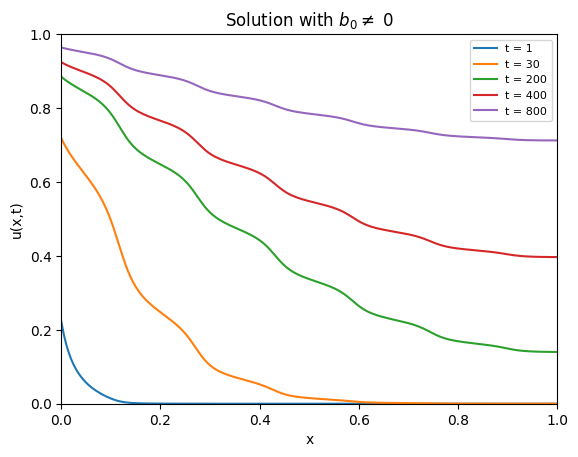

In [13]:
u = numerical_solution(D,f,a0,b0,c0,x,M,T)


dt = T/M; # time step
t = np.array([0.01,0.3,2,4,8]) # plot solution at these times only (must be multiples of dt)
indx = t/dt+1; # determine column index corresponding to specified times


plt.plot(x,u[:,1])
plt.plot(x,u[:,30])
plt.plot(x,u[:,200])
plt.plot(x,u[:,400])
plt.plot(x,u[:,800])
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x")
plt.ylabel(r'u(x,t)')
plt.title(r'Solution with $b_0 \neq$ 0')
plt.legend(["t = 1","t = 30", "t = 200", "t = 400","t = 800"], loc = 'upper right',prop = {'size': 8})
plt.show()

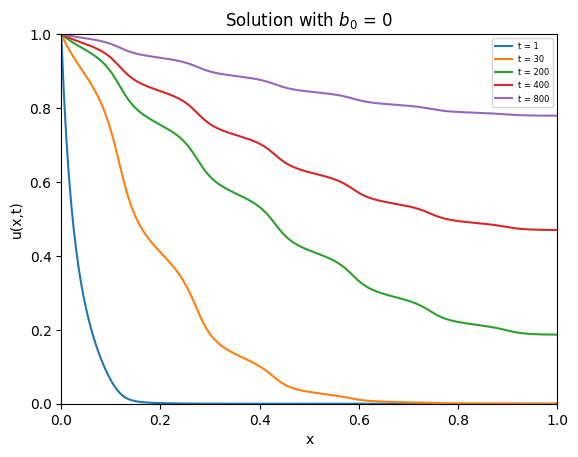

In [14]:
u = numerical_solution(D,f,a0,0,c0,x,M,T) # substitute b0 = 0


dt = T/M; # time step
t = np.array([0.01,0.3,2,4,8]) # plot solution at these times only (must be multiples of dt)
indx = t/dt+1; # determine column index corresponding to specified times


plt.plot(x,u[:,1])
plt.plot(x,u[:,30])
plt.plot(x,u[:,200])
plt.plot(x,u[:,400])
plt.plot(x,u[:,800])
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(r'Solution with $b_0$ = 0')
plt.legend(["t = 1","t = 30", "t = 200", "t = 400","t = 800"], loc = 'upper right',prop = {'size': 6})
plt.show()